# Breast Cancer Classification 
Breast cancer is a common cancer in women, and one of the major causes of death among women around the world. Invasive ductal carcinoma (IDC) is the most widespread type of breast cancer with about 80% of all diagnosed cases. IDC is cancer that began growing in a milk duct and has invaded the fibrous or fatty tissue of the breast outside of the duct. Early accurate diagnosis plays an important role in choosing the right treatment plan and improving survival rate among the patients. In recent years, efforts have been made to predict and detect all types of cancers by employing artificial intelligence. An appropriate dataset is the first essential step to achieve such a goal. This paper introduces a histopathological microscopy image dataset of 922 images related to 124 patients with IDC. The dataset has been published and is accessible through the web at: http://databiox.com. The distinctive feature of this dataset as compared to similar ones is that it contains an equal number of specimens from each of three grades of IDC, which leads to approximately 50 specimens for each grade.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/504px-Lobules_and_ducts_of_the_breast.jpg)

## Introduction

In Kenya, cancer is the third leading cause of death after infectious and cardiovascular diseases. From 2012 to 2018, the annual incidence of cancer increased from 37,000 to 47,887 new cases.7 During the same period, annual cancer mortality rose almost 16%, from 28,500 to 32,987 cancer-related deaths. The number of new cancer cases is expected to rise by more than 120% over the next 2 decades.

In [1]:
# data processing and linear algebra

import numpy as np 
import pandas as pd 
from numba import njit

#Data Visualiation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
import cv2 as cv

# Machine learning alogorithm
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras import Input, Model
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import keras


from glob import glob
from skimage import io
from os import listdir
import pickle
import random

import random
from pprint import pprint
import time
import copy
from IPython.display import Image
from tqdm.notebook import tqdm
tqdm().pandas();5

print('import complete')

import complete


/opt/conda/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
Image(filename='output/stats.jpg', width = 1000, height = 300)

## About the data
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

## Data preparation

In [ ]:
data = listdir("output/archive/IDC_regular_ps50_idx5")
len(data)

In [ ]:
file = listdir("output/archive")
len(file)

We have a total number of about 280 sub-folders, let's take a peak into the folder and try and understand what those sub-folders are.

Each subfolder seems to be the ID of the corresponding patient

In [ ]:
patient_file = listdir("output/archive/IDC_regular_ps50_idx5/13689")
len(patient_file)

Each file has 2 sub-folders, labeled 1 and 0

1. Folder 0: Non-Invasive Ductal Carcinoma (IDC)

2. Folder 1 : Invasive Ductal Carcinoma (IDC)

In [ ]:
zero = listdir('output/archive/IDC_regular_ps50_idx5/13689/0')
one = listdir('output/archive/IDC_regular_ps50_idx5/13689/1')
print(f"The number of NON IDC in Id 13689 is : {len(zero)}")
print(f"The number of IDC in Id 13689 is : {len(one)}")

# What do we know about our data?

1. Now that we have a good understanding of the file structure let's try and understand how much data we are about to process.

2. How many patients do we have?

    * It seems that we have a total number of 280 patients. 
    * This sample size is relatively small therefore we have to be careful not to overfit our model. We need to implement our model in such a way that it maximizes generalization.

3. Each patient has a batch of patches that were extracted, therefore the total number of patches is likely much greater than 280.

# NEXT STEP 

1. How many patches do we have in total?

2. Which of them are IDC patches and which are Non-IDC?

    * In order to train our model we need to feed our model each patch individually, therefore each patch will act as an input.

    * The snippet below loops through the entire file structure and extracts the total number of crops for each of the classes.

In [ ]:
train = 'output/archive/IDC_regular_ps50_idx5/'
patient_ids = listdir(train)

In [ ]:
class_0_total = 0
class_1_total = 0

In [ ]:
for patient_id in patient_ids:
    class_0_files = listdir(train + patient_id + '/0')
    class_1_files = listdir(train + patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 

total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Storing the image_path, patient_id, target and x & y coordinates

In [ ]:
columns = ["patient_id",'x','y',"target","path"]
data_rows = []
i = 0
iss = 0
isss = 0

# note that we loop through the classes after looping through the 
# patient ids so that we avoid splitting our data into [all class 0 then all class 1]
for patient_id in patient_ids:
    for c in [0,1]:
        class_path = train + patient_id + '/' + str(c) + '/'
        imgs = listdir(class_path)
        
        # Extracting Image Paths
        img_paths = [class_path + img + '/' for img in imgs]
        
        # Extracting Image Coordinates
        img_coords = [img.split('_',4)[2:4] for img in imgs]
        x_coords = [int(coords[0][1:]) for coords in img_coords]
        y_coords = [int(coords[1][1:]) for coords in img_coords]

        for (path,x,y) in zip(img_paths,x_coords,y_coords):
            values = [patient_id,x,y,c,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})

In [ ]:
# We create a new dataframe using the list of dicts that we generated above
data = pd.DataFrame(data_rows)
print(data.shape)
data

## Data Analysis

Now that we have set up our data, let's create a visual summary to help us draw some insights from our data.

In [ ]:
#default theme
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(25,5))

# Plotting Frequency of Patches per Patient
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="green", kde=False, bins=20)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plotting Percentage of an image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="red", kde=False, bins=20)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Plotting number of patches that show IDC
sns.countplot(data.target, palette='pastel', ax=ax[2]);
ax[2].set_ylabel("Count")
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Healthy Tissue Patches Vs Cancerous Tissue Patches
Let us now explore the visual differences between cancerous tissue cells, and healthy tissue cells. 
Usually partnering with a specialist is a good idea so that they can point the exact points of interest that differentiate the 2 from each other.

In [ ]:
positive_tissue = np.random.choice(data[data.target==1].index.values, size=100, replace=False)
negative_tissue = np.random.choice(data[data.target==0].index.values, size=100, replace=False)

In [ ]:
n_rows = 5
n_cols = 5

### A ) Cancerous Patches

In [ ]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = positive_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

### B) Non-Cancerous Patches

In [ ]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indices
        idx = negative_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

### Visualizing the Breast Tissue

Earlier we extracted the coordinates of the cropped tissue cells, we can use those coordinates to reconstruct the whole breast tissue of the patient. This way we can explore how the diseased tissue looks when compared to the healthy tissue.

We can also explore the most common places that the cancer tends to occur in. It would be interesting to plot a heatmap of the most common areas where the cancer appears.

If position of the crop has significance then perhaps we can use it as an input feature for our model.

To simplify things we will create a function that slices our existing dataframe and retrieves the values associated with a patient id.

In [ ]:
def get_patient_df(patient_id):
    return data.loc[data['patient_id']== patient_id,:]

In [ ]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols

In [ ]:
colors = ['pink', 'red']

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 22))

patient_ids = np.random.choice( data.patient_id.unique(), size=n_imgs, replace=False)

for row in range(n_rows):
    for col in range(n_cols):
        patient_id = patient_ids[col + n_cols*row]
        patient_df = get_patient_df(patient_id)
        
        ax[row,col].scatter(patient_df.x.values, \
                            patient_df.y.values, \
                            c=patient_df.target.values,\
                            cmap=ListedColormap(colors), s=20)
        ax[row,col].set_title("patient " + patient_id)

###  Insights

1. Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.
2. Cancerous Tissue tends to appear in clusters rather than, being dispersed all over the place.

### Repatching the Actual Breast Tissue Image

Now it's time to go one step deeper with our EDA. Instead of plotting the target values using the x-y coordinates, we now plot the images themselves on their respective x-y coordinates. This will help us visualize how the cancerous tissue looks like from a macro perspective.

uint8 is used unsigned 8 bit integer. And that is the range of pixel. We can't have pixel value more than 2^8 -1. Therefore, for images uint8 type is used. Whereas double is used to handle very big numbers.

In [ ]:
def visualise_breast_tissue(patient_id, df = data,pred = False, crop_dimension = [50,50]):
    # Plotting Settings
    plt.xticks([])
    plt.yticks([])
    # Get patient dataframe
    p_df = get_patient_df(patient_id)
    # Get the dimensions of the breast tissue image
    max_coord = np.max((*p_df.x,*p_df.y))
    # Allocate an array to fill image pixels in,use uint8 type as you don't need an int over 255
    grid = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    # Replace array values with values of the image
    for x,y,target,path in zip(p_df['x'],p_df['y'],p_df['target'],p_df['path']):
        try:
            img = io.imread(path)
            # Replace array values with cropped image values
            grid[y:y+crop_dimension[1],x:x+crop_dimension[0]] = img
            # Check if target is cancerous or not
            if target != 0:
                # If the target is cancerous then, replace array values with the color blue
                mask[y:y+crop_dimension[1],x:x+crop_dimension[0]] = [0,0,255]
        except: pass
    # if prediction is not specifies then show the image normally
    if pred == False:
        io.imshow(grid)
        img = grid
    # if prediction is specified then apply a mask to the areas that contain predicted cancerous cells
    else:
        # Specify the desired alpha value
        alpha = 0.78
        # This is step is very important, adding 2 numpy arrays sets the values to float64, which is why convert them back to uint8
        img = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
        io.imshow(img)
    return img

In [ ]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols

In [ ]:
fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 27))

for row in range(n_rows):
    for col in range(n_cols):
        p_id = patient_ids[col + n_cols*row]
        
        img = visualise_breast_tissue(p_id, pred = True)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Breast tissue slice of patient: " + p_id)        
        ax[row,col].imshow(img)

In [2]:
# Get the file dir
breast_img = glob('output/archive/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [3]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)

In [4]:
non_num = len(non_img)
can_num = len(can_img)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


## Oversampling 

In [5]:
#can_img = can_img * 2

In [6]:
some_non_img = random.sample(non_img, len(can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:   
    n_img = cv.imread(img, cv.IMREAD_COLOR)
    n_img_size = cv.resize(n_img, (50, 50), interpolation = cv.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in some_can_img:
    c_img = cv.imread(img, cv.IMREAD_COLOR)
    c_img_size = cv.resize(c_img, (50, 50), interpolation = cv.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [7]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print('X shape : {}' .format(X.shape))

X shape : (157572, 50, 50, 3)


## Data Scaling

In [8]:
X = X/255

In [9]:
X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size = 0.2, random_state = 128)

rate = 0.8
num = int(X_train.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (100845, 50, 50, 3)
X_test shape : (25212, 50, 50, 3)
X_predict shape : (31515, 50, 50, 3)
y_train shape : (100845, 2)
y_test shape : (25212, 2)
y_true shape : (31515, 2)


## Convolutional neural networks (CNN) 
CNN emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. According to Aurelien, CNNs have man‐
aged to achieve superhuman performance on some complex visual tasks. Some of their application include:
* Power image search services
* Self-driving cars
* Automatic video classification systems

### Convolutional Layer

Convolution is a linear operation that involves the multiplication of a set of weights with the input, much like a traditional neural network.

Given that the technique was designed for two-dimensional input, the multiplication is performed between an array of input data and a two-dimensional array of weights, called a filter or a kernel.

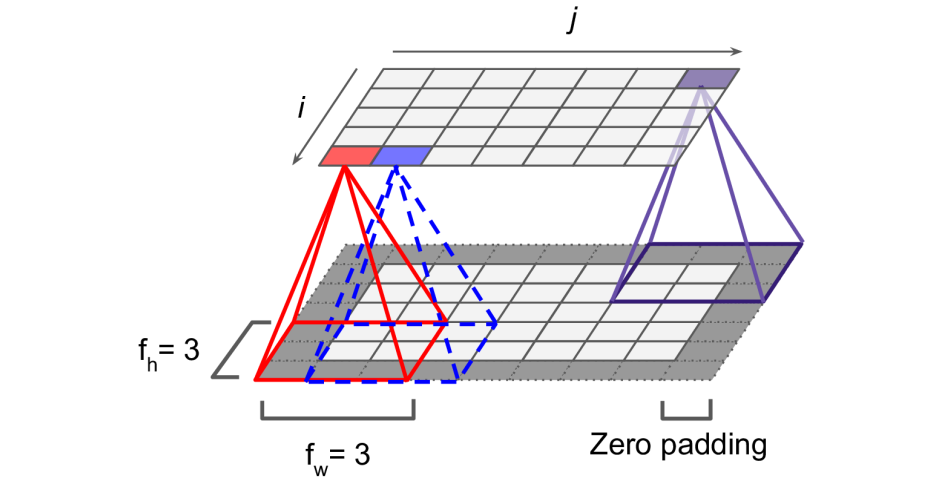

In [10]:
Image(filename='output/conv.png', width = 1500, height = 700)

### Pooling Layer

Their goal is to subsample (i.e., shrink) the input image in order to reduce:
* The computational load
* The memory usage
* The number of parameters (thereby limiting the risk of overfitting).

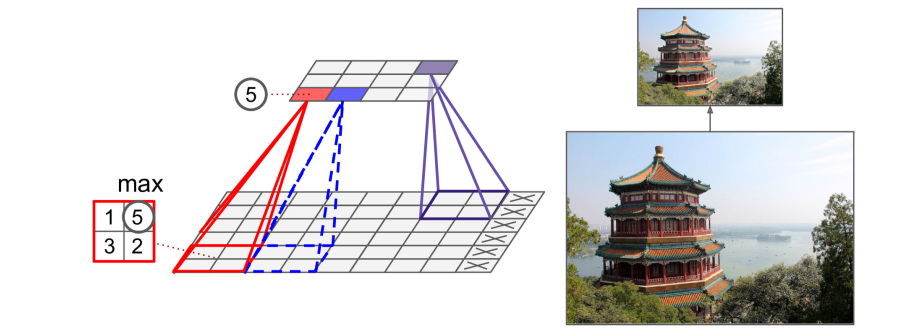

In [11]:
Image(filename='output/maxpool.png', width = 1500, height = 700)

In [12]:
def get_model(inp_shape = (50, 50, 3)):
    inp = Input(inp_shape)
    m = Conv2D(32, (3, 3) , padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    m = Dropout(0.25)(m)
    
    m = Conv2D(64, (3, 3), padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Dropout(0.25)(m)
    
    m = Conv2D(128, (3, 3), padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Dropout(0.25)(m)
    
    m = Conv2D(128, (3, 3), padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Dropout(0.25)(m)
    
    m = Flatten()(m)
    m = Dense(128, activation = "relu")(m)
    
    m = Dropout(0.5)(m)
    out = Dense(2, activation = "sigmoid")(m)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate = 0.0001), loss="binary_crossentropy", metrics = ['accuracy'])
    return model

In [13]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0     

In [14]:
callbacks = [keras.callbacks.EarlyStopping(monitor="loss", patience=3)]

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 256, callbacks=callbacks)

Epoch 1/30
199/394 [==============>...............] - ETA: 55s - loss: 0.4418 - accuracy: 0.8344

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(X_test, y_test, batch_size = 256)
print('Test Loss, Test Accuracy :', result)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_predict)

true = 0
for i in range(X_predict.shape[0]):
    if(np.argmax(y_pred[i]) == np.argmax(y_true[i])):
        true = true + 1

pre_accuracy = 100 * float(true/X_predict.shape[0])        
print('Predict Accuracy: {}' .format(pre_accuracy))

## Model Evaluation
* Precision: It can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”
* Recall: It is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”
* f1 score: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
* support: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [ ]:
print(classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
mat = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(mat, annot=True, annot_kws={"size": 16})

## Visualizing Filters
CNN uses learned filters to convolve the feature maps from the previous layer. Filters are two- dimensional weights and these weights have a spatial relationship with each other.


In [ ]:
def plot_filters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            plot_filters(filt)

## Visualizing Feature maps
Feature maps are generated by applying filters to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations for specific input for each of the Convolutional layers in the model.

In [ ]:
def visualize_feture_maps(model, img_path='output/archive/8863/1/8863_idx5_x1001_y801_class1.png'):
    # Define a new Model, Input= image 
    # Output= intermediate representations for all layers in the  
    # previous model after the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]
    # visualization_model = Model(img_input, successive_outputs)
    visualization_model = keras.models.Model(inputs = model.input, outputs = successive_outputs)
    # Read the input image
    x = cv.imread(img_path, cv.IMREAD_COLOR)
    x = cv.resize(x, (50, 50), interpolation = cv.INTER_LINEAR)
    x = x/255
    x = np.expand_dims(x, axis=0)
    # Let's run our image through our network, thus obtaining all
    # intermediate representations for this image.
    successive_feature_maps = visualization_model.predict(x)
    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers]
    # -----------------------------------------------------------------------
    # Now let's display our representations
    # -----------------------------------------------------------------------
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
      print(feature_map.shape)
      if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
          x  = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [ ]:
visualize_feture_maps(model, img_path='output/archive/8863/1/8863_idx5_x1001_y801_class1.png')

In [ ]:
visualize_feture_maps(model, img_path='output/archive/8863/0/8863_idx5_x101_y1301_class0.png')

## References
Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O'Reilly Media.

Cancer on the Global Stage: Incidence and Cancer-Related Mortality in Kenya - The ASCO Post. (2021). Retrieved 10 August 2021, from https://ascopost.com/issues/february-25-2021/cancer-on-the-global-stage-incidence-and-cancer-related-mortality-in-kenya/